***
# Calidad de Vinos

## Análisis exploratorio de datos

In [2]:
import numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("winequality-red.csv")

In [4]:
data.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


#### 12 variables (incluida Quality que es la variable a predecir) y 1599 observaciones

In [5]:
data_shape = data.shape
data_shape

(1599, 12)

#### Variable que contiene el nombre de las columnas

In [6]:
col_name = data.columns

#### Se buscan valores nulos en el data set

In [7]:
np.sum(data.isnull().sum())

0

#### Se buscan columnas con valores constantes en el data set

In [8]:
unique_col = data.apply(pd.Series.nunique)
repeat_col = unique_col[unique_col == 1].index
repeat_col

Index([], dtype='object')

#### Variables correlacionadas - Heatmap

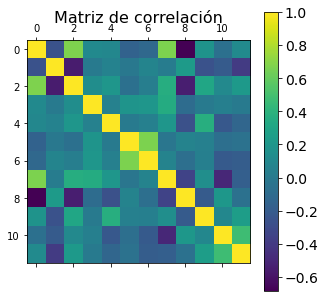

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.matshow(data.corr(), fignum=fig.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Matriz de correlación", fontsize=16);

In [10]:
plt.style.use('seaborn-whitegrid')

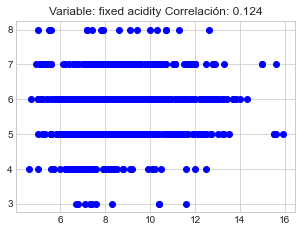

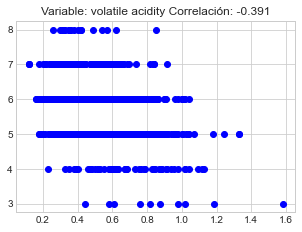

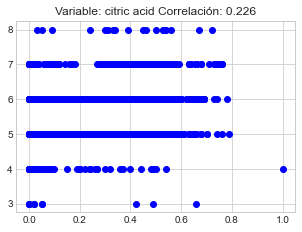

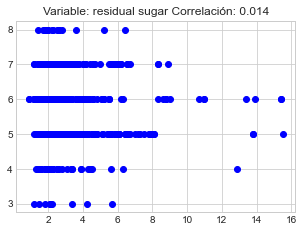

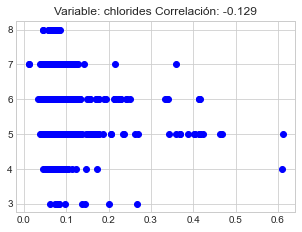

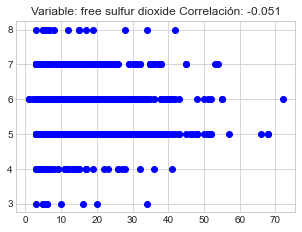

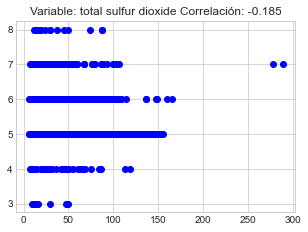

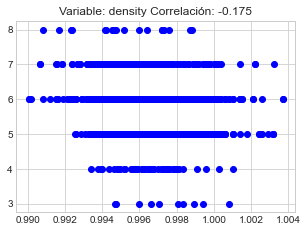

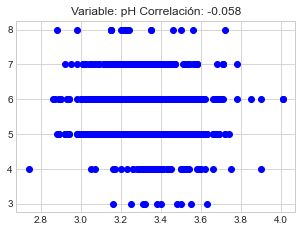

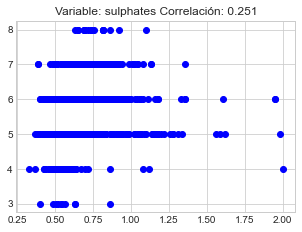

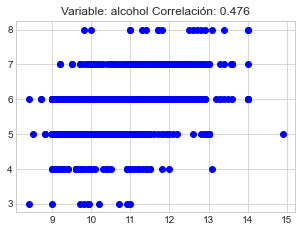

In [11]:
data_set = data.values
corr = data.corr()

for x in range(1, 12):
    graficas = plt.figure(figsize = (5,50))
    plt.subplot(12, 1, x)
    plt.scatter(x = data_set[::, x-1], y = data_set[::, 11], color = "b")
    plt.title("Variable: "+ col_name[x-1] + " Correlación: "+ str('%.3f' % corr["quality"][x - 1]))

#### Variables seleccionadas para la construcción del modelo

In [12]:
print("Nombre variable: " + col_name[1])
print("Correlación: " + str(corr["quality"][1]))

Nombre variable: volatile acidity
Correlación: -0.3905577802640094


In [13]:
print("Nombre variable: " + col_name[10])
print("Correlación: " + str(corr["quality"][10]))

Nombre variable: alcohol
Correlación: 0.47616632400114156


#### Creando el modelo polinomio de grado 2

In [14]:
#Cantidad de variables y grado polinomio:
Var = 6
Pol = 2

In [15]:
Y_data = np.array(data_set[:,11]).reshape((data_set.shape[0], 1))
A = data_set[:,1]
B = data_set[:,10]
A2 = np.power(A, 2)
B2 = np.power(B, 2)
AB = A*B
pol_2 = np.vstack((np.ones(A.shape), A, B, A2, B2, AB)).T

In [16]:
print(Y_data.shape)

(1599, 1)


In [18]:
tf.reset_default_graph()

grafo = tf.Graph()
with grafo.as_default() as g:
    X = tf.placeholder("float", (None, Var),name = "X")
    Y = tf.placeholder("float", (None, 1), name = "Y")
    lr = tf.placeholder(tf.float32, name = "lr")
    b = tf.Variable(tf.zeros(1), name = "b", dtype = "float")
    W = tf.Variable(tf.zeros((Var, 1)), name = "W", dtype = "float")
    #-----------
    with tf.name_scope('y_hat') as scope:
        y_hat = tf.matmul(X, W) + b
    with tf.name_scope('cost') as scope:
        cost = tf.multiply(tf.reduce_mean(tf.pow(y_hat - Y, 2.0)), 0.5)
        cost_summary = tf.summary.scalar("cost", cost)
    with tf.name_scope('optimizer') as scope:
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    init = tf.global_variables_initializer()

In [19]:
def train_regresion_polinomial_2(data_x, data_y, t_epoch, l_r, num_prueba):
    with tf.Session(graph = grafo) as sess:
        writer = tf.summary.FileWriter("./graphs/Pol_"+str(Pol)+"_Prueba_"+str(num_prueba)+"_lr_"+str(l_r), \
                                       sess.graph)
        sess.run(init)
        for epoch in range(t_epoch):
            sess.run(optimizer, feed_dict = {X : data_x, Y : data_y, lr : l_r})
            training_cost, weight, bias = sess.run([cost, W, b], \
                                                   feed_dict = {X : data_x, \
                                                                Y : data_y, \
                                                                lr : l_r})
            if (epoch + 1) % 10 == 0:
                c, training_cost, weight, bias = sess.run([cost_summary, cost, W, b], \
                                                          feed_dict = {X : data_x, \
                                                                       Y : data_y, \
                                                                       lr : l_r})
                writer.add_summary(c, epoch+1)
            if (epoch + 1) % t_epoch == 0:
                print("Epoch", (epoch + 1), ": cost =", training_cost, "W =", weight.T, "b =", bias)
        writer.close()
    return [bias, weight.T, training_cost]

#### Entrenando el modelo para un polinomio de grado 2
Se muestra el costo y los pesos de la última iteración para cada learning rate.

In [20]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [21]:
resultado = []
for num, lrates in enumerate(learning_rates):
    resultado.append(train_regresion_polinomial_2(pol_2, Y_data, 1000, lrates, num))

Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = 0.48725724 W = [[0.01532939 0.00591009 0.08487578 0.0015645  0.04055604 0.02336069]] b = [0.0153294]
Epoch 1000 : cost = 0.5531199 W = [[0.00203264 0.00090636 0.01321327 0.00036935 0.0483305  0.00537195]] b = [0.00203264]
Epoch 1000 : cost = 0.5612213 W = [[0.00059156 0.00029337 0.00544876 0.00015551 0.04920907 0.002675  ]] b = [0.00059156]


***
#### Creando el modelo polinomio de grado 3

In [22]:
Var = 10
Pol = 3
A = data_set[:,1]
B = data_set[:,10]
A2 = np.power(A, 2)
B2 = np.power(B, 2)
A3 = np.power(A, 3)
B3 = np.power(B, 3)
AB = A*B
AB2 = A*np.power(B,2)
BA2 = B*np.power(A,2)

pol_3 = np.vstack((np.ones(A.shape), A, B, A2, B2, AB, AB2, BA2, A3, B3)).T

In [23]:
tf.reset_default_graph()

grafo = tf.Graph()
with grafo.as_default() as g:
    X = tf.placeholder("float", (None, Var),name = "X")
    Y = tf.placeholder("float", (None, 1), name = "Y")
    lr = tf.placeholder(tf.float32, name = "lr")
    b = tf.Variable(tf.zeros(1), name = "b", dtype = "float")
    W = tf.Variable(tf.zeros((Var, 1)), name = "W", dtype = "float")
    #-----------
    with tf.name_scope('y_hat') as scope:
        y_hat = tf.matmul(X, W) + b
    with tf.name_scope('cost') as scope:
        cost = tf.multiply(tf.reduce_mean(tf.pow(y_hat - Y, 2.0)), 0.5)
        cost_summary = tf.summary.scalar("cost", cost)
    with tf.name_scope('optimizer') as scope:
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    init = tf.global_variables_initializer()

#### Entrenando el modelo para un polinomio de grado 3
Se muestra el costo y los pesos de la última iteración para cada learning rate.

In [24]:
resultado_pol_3 = []
for num, lrates in enumerate(learning_rates):
    resultado_pol_3.append(train_regresion_polinomial_2(pol_3, Y_data, 1000, lrates, num))

Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = nan W = [[nan nan nan nan nan nan nan nan nan nan]] b = [nan]
Epoch 1000 : cost = 0.92846686 W = [[3.9240631e-04 1.9239850e-04 2.8429541e-03 9.5118674e-05 1.5663745e-02
  1.3673727e-03 7.1867555e-03 6.2953733e-04 4.1992254e-05 2.6664496e-03]] b = [0.00039241]


![Grafo](grafo.png)

![graficas](l_r.png)

## Conclusiones:

* Analizando las gráficas se puede observar que de todas las pruebas realizadas el mejor resultado se obtuvo en el polinomio de grado 2 con un learning rate igual a 0.00001
* Es posible que al tranformar otras features por ejemplo obtener relaciones logaritmicas o exponenciales se pueda obtener un mejor resultado así como normalizar nuestra data antes de entrenar el modelo.
* Es preferible utilizar modelos con menor complejidad mientras cumplan con los parametros deseados o establecidos para validar un modelo.